In [1]:
import numpy as np

class CardGameEnv:
    def __init__(self):
        self.reset()

    def draw_card(self):
        value = np.random.randint(1, 14)
        color = 'black' if np.random.rand() < 2/3 else 'red'
        return value, color

    def reset(self):
        self.player_sum = 0
        self.dealer_sum = 0
        self.player_cards = []
        self.dealer_cards = []
        # Both player and dealer start with a black card
        player_card, _ = self.draw_card()
        dealer_card, _ = self.draw_card()
        self.player_sum += player_card
        self.dealer_sum += dealer_card
        self.player_cards.append(player_card)
        self.dealer_cards.append(dealer_card)
        self.done = False
        return self.get_state()

    def get_state(self):
        return (self.dealer_cards[0], self.player_sum)

    def step(self, state, action):
        if action == 'hit':
            card_value, card_color = self.draw_card()
            if card_color == 'black':
                self.player_sum += card_value
            else:
                self.player_sum -= card_value
            self.player_cards.append((card_value, card_color))
            
            if self.player_sum > 21 or self.player_sum < 1:
                return self.get_state(), -1, True  # Player goes bust
            else:
                return self.get_state(), 0, False  # Continue playing
        
        elif action == 'stick':
            while self.dealer_sum < 17:
                card_value, card_color = self.draw_card()
                if card_color == 'black':
                    self.dealer_sum += card_value
                else:
                    self.dealer_sum -= card_value
                self.dealer_cards.append((card_value, card_color))
                
                if self.dealer_sum > 21 or self.dealer_sum < 1:
                    return self.get_state(), 1, True  # Dealer goes bust, player wins

            # Determine winner
            if self.dealer_sum == self.player_sum:
                return self.get_state(), 0, True  # Draw
            elif self.dealer_sum > self.player_sum:
                return self.get_state(), -1, True  # Dealer wins
            else:
                return self.get_state(), 1, True  # Player wins

# Example usage:
env = CardGameEnv()
state = env.reset()
print(state)
new_state, reward, done = env.step(state, 'hit')
print(new_state, reward, done)


(8, 13)
(8, 17) 0 False


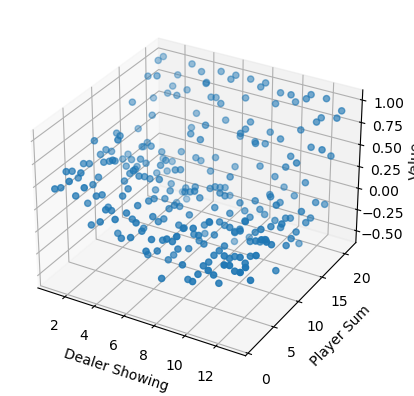

In [2]:
import matplotlib.pyplot as plt
from collections import defaultdict

def epsilon_greedy_policy(Q, state, N0, N):
    epsilon = N0 / (N0 + N[state])
    if np.random.rand() < epsilon:
        return np.random.choice(['hit', 'stick'])
    else:
        return max(Q[state], key=Q[state].get)

def monte_carlo_control(env, num_episodes, N0):
    Q = defaultdict(lambda: {'hit': 0, 'stick': 0})
    N = defaultdict(int)
    N_sa = defaultdict(lambda: {'hit': 0, 'stick': 0})

    for episode in range(num_episodes):
        episode_history = []
        state = env.reset()
        done = False

        while not done:
            action = epsilon_greedy_policy(Q, state, N0, N)
            next_state, reward, done = env.step(state, action)
            episode_history.append((state, action, reward))
            state = next_state

        G = 0
        for state, action, reward in reversed(episode_history):
            G = reward + G
            N[state] += 1
            N_sa[state][action] += 1
            Q[state][action] += (G - Q[state][action]) / N_sa[state][action]

    return Q

env = CardGameEnv()
Q_mc = monte_carlo_control(env, num_episodes=10000, N0=100)

# Extract the value function
V_mc = defaultdict(float)
for state in Q_mc:
    V_mc[state] = max(Q_mc[state].values())

# Plot the value function
X, Y, Z = [], [], []
for (dealer, player), value in V_mc.items():
    X.append(dealer)
    Y.append(player)
    Z.append(value)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X, Y, Z)
ax.set_xlabel('Dealer Showing')
ax.set_ylabel('Player Sum')
ax.set_zlabel('Value')
plt.show()


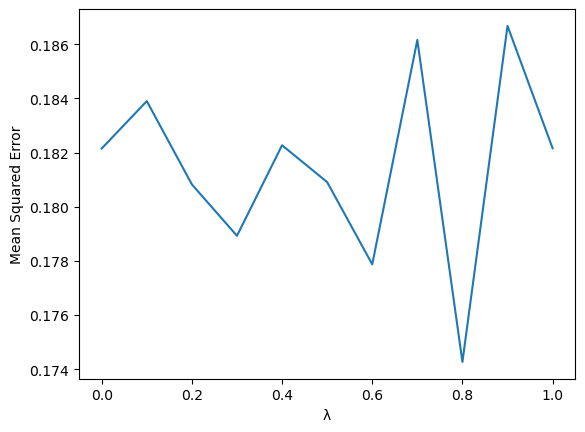

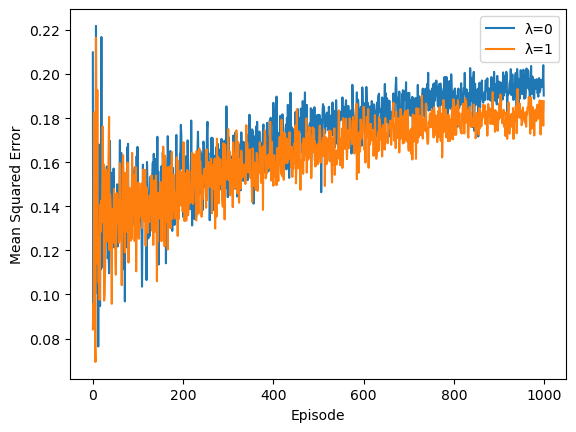

In [3]:
def sarsa_lambda(env, num_episodes, lambd, N0):
    Q = defaultdict(lambda: {'hit': 0, 'stick': 0})
    N = defaultdict(int)
    N_sa = defaultdict(lambda: {'hit': 0, 'stick': 0})

    for episode in range(num_episodes):
        state = env.reset()
        action = epsilon_greedy_policy(Q, state, N0, N)
        done = False
        E = defaultdict(lambda: {'hit': 0, 'stick': 0})

        while not done:
            next_state, reward, done = env.step(state, action)
            next_action = epsilon_greedy_policy(Q, next_state, N0, N)
            delta = reward + (Q[next_state][next_action] if not done else 0) - Q[state][action]
            E[state][action] += 1

            for s in Q:
                for a in Q[s]:
                    Q[s][a] += (delta * E[s][a]) / N_sa[s][a] if N_sa[s][a] > 0 else 0
                    E[s][a] *= lambd

            state, action = next_state, next_action

    return Q

# Compute true Q* values using Monte Carlo control
Q_star = monte_carlo_control(env, num_episodes=10000, N0=100)

lambdas = np.arange(0, 1.1, 0.1)
mse_values = []

for lambd in lambdas:
    Q_sarsa = sarsa_lambda(env, num_episodes=1000, lambd=lambd, N0=100)
    mse = np.mean([(Q_sarsa[s][a] - Q_star[s][a]) ** 2 for s in Q_sarsa for a in Q_sarsa[s]])
    mse_values.append(mse)

plt.plot(lambdas, mse_values)
plt.xlabel('λ')
plt.ylabel('Mean Squared Error')
plt.show()

# Plot learning curve for λ = 0 and λ = 1
for lambd in [0, 1]:
    mse_values = []
    Q_star = monte_carlo_control(env, num_episodes=10000, N0=100)
    for episode in range(1000):
        Q_sarsa = sarsa_lambda(env, num_episodes=episode+1, lambd=lambd, N0=100)
        mse = np.mean([(Q_sarsa[s][a] - Q_star[s][a]) ** 2 for s in Q_sarsa for a in Q_sarsa[s]])
        mse_values.append(mse)
    plt.plot(range(1000), mse_values, label=f'λ={lambd}')
plt.xlabel('Episode')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()
